# Imports

In [1]:
import comet_ml
from comet_ml import Experiment
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt

In [2]:
import transformers
from transformers import *
import numpy as np
from datasets import load_dataset
import evaluate
from tqdm import tqdm

comet_ml is installed but `COMET_API_KEY` is not set.
/Users/milosz/opt/miniconda3/envs/pt/lib/python3.9/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [3]:
from datasets import load_dataset
import datasets

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [5]:
RANDOM_SEED = 42
VALIDATION_PERCENTAGE = 10
# PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
# PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
PRE_TRAINED_MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"

# Load and prepare data

In [6]:
full_train_dataset = load_dataset("csv", data_files="p6/train_data.csv")

train_dataset, valid_dataset = datasets.load_dataset("csv", data_files="p6/train_data.csv", split=[
    datasets.ReadInstruction('train', to=100-VALIDATION_PERCENTAGE, unit='%'),
    datasets.ReadInstruction('train', from_=-VALIDATION_PERCENTAGE, unit='%'),
])

test_dataset = load_dataset("csv", data_files="p6/test_data.csv", column_names=['review'])

Using custom data configuration default-09e2066563176d94
Found cached dataset csv (/Users/milosz/.cache/huggingface/datasets/csv/default-09e2066563176d94/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-09e2066563176d94
Found cached dataset csv (/Users/milosz/.cache/huggingface/datasets/csv/default-09e2066563176d94/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration default-87d9d524b2970477
Found cached dataset csv (/Users/milosz/.cache/huggingface/datasets/csv/default-87d9d524b2970477/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# rename label column
full_train_dataset = full_train_dataset.rename_column('rating', 'label')
train_dataset = train_dataset.rename_column('rating', 'label')
valid_dataset = valid_dataset.rename_column('rating', 'label')

In [8]:
print(full_train_dataset)

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 16392
    })
})


In [9]:
print(train_dataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 14753
})


In [10]:
print(valid_dataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 1639
})


In [11]:
print(test_dataset)

DatasetDict({
    train: Dataset({
        features: ['review'],
        num_rows: 4099
    })
})


(array([1137.,    0., 1434.,    0.,    0., 1747.,    0., 4831.,    0.,
        7243.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

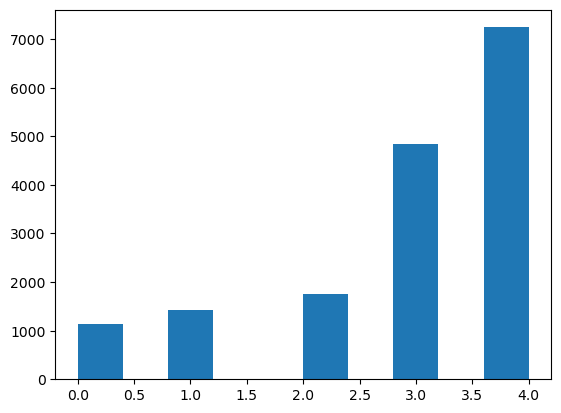

In [12]:
plt.hist(full_train_dataset['train']['label'])

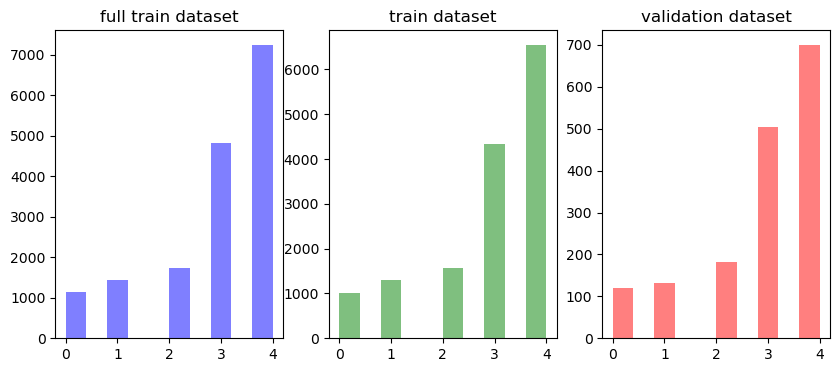

In [13]:
# Create a 3x1 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(10,4))

# Plot the first histogram in the first subplot
axs[0].hist(full_train_dataset['train']['label'], color='blue', alpha=0.5)
axs[0].set_title('full train dataset')

# Plot the second histogram in the second subplot
axs[1].hist(train_dataset['label'], color='green', alpha=0.5)
axs[1].set_title('train dataset')

# Plot the third histogram in the third subplot
axs[2].hist(valid_dataset['label'], color='red', alpha=0.5)
axs[2].set_title('validation dataset')

plt.show()

## Tokenization

In [14]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

def tokenize_function(data):
    return tokenizer(data["review"], padding="max_length", truncation=True)


tokenized_train_df = train_dataset.map(tokenize_function, batched=True)
tokenized_valid_df = valid_dataset.map(tokenize_function, batched=True)

tokenized_train_df = tokenized_train_df.remove_columns(['review'])
tokenized_valid_df = tokenized_valid_df.remove_columns(['review'])

tokenized_train_df.set_format("torch")
tokenized_valid_df.set_format("torch")

# train_df = tokenized_train_df.shuffle(seed=RANDOM_SEED).select(range(200))
# valid_df = tokenized_valid_df.shuffle(seed=RANDOM_SEED).select(range(100))
train_df = tokenized_train_df
valid_df = tokenized_valid_df

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loading configuration file config.json from cache at /Users/milosz/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/e06857fdb0325a7798a8fc361b417dfeec3a3b98/config.json
Model config BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads"

In [15]:
print(train_df)

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 14753
})


In [16]:
print(valid_df)

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1639
})


# Define model

In [17]:
# model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, num_labels=5
)

loading configuration file config.json from cache at /Users/milosz/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/e06857fdb0325a7798a8fc361b417dfeec3a3b98/config.json
Model config BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads"

In [18]:
training_arguments = TrainingArguments(
    seed=RANDOM_SEED,
    optim="adamw_torch",
    learning_rate=5e-5,
    num_train_epochs=100,
    output_dir="./results",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=25,
    save_strategy="steps",
    save_total_limit=10,
    save_steps=25,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [19]:
# read comet API key from a file
with open('api_key.txt', 'r') as file:
    API_KEY = file.readline().strip()

In [ ]:
experiment = Experiment(
    api_key=API_KEY,
    project_name="hotel_stars_v1",
    workspace="milosz-l",
)

In [20]:
def compute_metrics(pred):
    
    #get global experiments
    # experiment = comet_ml.get_global_experiment()
    
    #get y_true and y_preds for eval_dataset
    # print(f'pred = {pred}')
    labels = pred.label_ids
    # print(f'labels = {labels}')
    preds = pred.predictions.argmax(-1)
    # print(f'preds = {preds}')
    
    #compute precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro')
    
    #compute accuracy score
    acc = accuracy_score(labels, preds)
    
    #log confusion matrix
    if experiment:
        epoch = int(experiment.curr_epoch) if experiment.curr_epoch is not None else 0
        experiment.set_epoch(epoch)
        experiment.log_confusion_matrix(
            y_true=labels,
            y_predicted=preds,
            labels=[1, 2, 3, 4, 5]
        )

    return {"accuracy": acc, 
            "f1": f1, 
            "precision": precision,
            "recall": recall
            }

In [21]:
%env COMET_MODE=ONLINE
%env COMET_LOG_ASSETS=TRUE
trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_df,
    eval_dataset=valid_df,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

env: COMET_MODE=ONLINE
env: COMET_LOG_ASSETS=TRUE


In [22]:
trainer.train()

***** Running training *****
  Num examples = 14753
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 184500
  Number of trainable parameters = 167360261


  0%|          | 0/184500 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/milosz-l/hugging-face-text-classification/522fdfc251c941bfa99ba16bc49c6473

Saving model checkpoint to ./results/checkpoint-25
Configuration saved in ./results/checkpoint-25/config.json


{'eval_loss': 0.8936576247215271, 'eval_accuracy': 0.5942647956070775, 'eval_f1': 0.5130178366355332, 'eval_precision': 0.5935746880143865, 'eval_recall': 0.5148604075317772, 'eval_runtime': 306.8444, 'eval_samples_per_second': 5.341, 'eval_steps_per_second': 0.668, 'epoch': 0.01}


Model weights saved in ./results/checkpoint-25/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/522fdfc251c941bfa99ba16bc49c6473
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5942647956070775
COMET INFO:     eval/f1                 : 0.5130178366355332
COMET INFO:     eval/loss               : 0.8936576247215271
COMET INFO:     eval/precision          : 0.5935746880143865
COMET INFO:     eval/recall             : 0.5148604075317772
COMET INFO:     eval/runtime            : 306.8444
COMET INFO:     eval/samples_per_second : 5.341
COMET INFO:     eval/steps_per_second   : 0.668
COMET INFO:     loss [3]                : (0.5783105492591858, 1.030928611755371)
COMET INFO:     train/epoch             : 0.01
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 1.1084538698196411, 'eval_accuracy': 0.5216595485051861, 'eval_f1': 0.35901620748276236, 'eval_precision': 0.6283891728754287, 'eval_recall': 0.3945123642952704, 'eval_runtime': 318.3114, 'eval_samples_per_second': 5.149, 'eval_steps_per_second': 0.644, 'epoch': 0.03}


Model weights saved in ./results/checkpoint-50/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/39a6c67435154da8aa8cc76a868d7fc6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5216595485051861
COMET INFO:     eval/f1                 : 0.35901620748276236
COMET INFO:     eval/loss               : 1.1084538698196411
COMET INFO:     eval/precision          : 0.6283891728754287
COMET INFO:     eval/recall             : 0.3945123642952704
COMET INFO:     eval/runtime            : 318.3114
COMET INFO:     eval/samples_per_second : 5.149
COMET INFO:     eval/steps_per_second   : 0.644
COMET INFO:     loss [2]                : (0.9538020491600037, 1.2648245096206665)
COMET INFO:     train/epoch             : 0.03
COMET INFO:   Uploads:
COMET INFO:     conda-environment

{'eval_loss': 1.0585604906082153, 'eval_accuracy': 0.5332519829164124, 'eval_f1': 0.34128747846796825, 'eval_precision': 0.3471922977215843, 'eval_recall': 0.35097173569187384, 'eval_runtime': 318.7077, 'eval_samples_per_second': 5.143, 'eval_steps_per_second': 0.643, 'epoch': 0.04}


Model weights saved in ./results/checkpoint-75/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/9f4c2c41414440439bf397b7fde30b87
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5332519829164124
COMET INFO:     eval/f1                 : 0.34128747846796825
COMET INFO:     eval/loss               : 1.0585604906082153
COMET INFO:     eval/precision          : 0.3471922977215843
COMET INFO:     eval/recall             : 0.35097173569187384
COMET INFO:     eval/runtime            : 318.7077
COMET INFO:     eval/samples_per_second : 5.143
COMET INFO:     eval/steps_per_second   : 0.643
COMET INFO:     loss [3]                : (0.7336978912353516, 1.2897533178329468)
COMET INFO:     train/epoch             : 0.04
COMET INFO:   Uploads:
COMET INFO:     conda-environmen

{'eval_loss': 0.995583713054657, 'eval_accuracy': 0.5729103111653447, 'eval_f1': 0.5172011759409434, 'eval_precision': 0.5086742587854418, 'eval_recall': 0.5331546878623998, 'eval_runtime': 320.2151, 'eval_samples_per_second': 5.118, 'eval_steps_per_second': 0.64, 'epoch': 0.05}


Model weights saved in ./results/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/299d9a97ac0947e2a1ac68564b16f53d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5729103111653447
COMET INFO:     eval/f1                 : 0.5172011759409434
COMET INFO:     eval/loss               : 0.995583713054657
COMET INFO:     eval/precision          : 0.5086742587854418
COMET INFO:     eval/recall             : 0.5331546878623998
COMET INFO:     eval/runtime            : 320.2151
COMET INFO:     eval/samples_per_second : 5.118
COMET INFO:     eval/steps_per_second   : 0.64
COMET INFO:     loss [2]                : (0.9289406538009644, 1.0063583850860596)
COMET INFO:     train/epoch             : 0.05
COMET INFO:   Uploads:
COMET INFO:     conda-environment-de

{'eval_loss': 0.9079111814498901, 'eval_accuracy': 0.5979255643685174, 'eval_f1': 0.5287702898890336, 'eval_precision': 0.5852276701957331, 'eval_recall': 0.5083249997373838, 'eval_runtime': 318.8849, 'eval_samples_per_second': 5.14, 'eval_steps_per_second': 0.643, 'epoch': 0.07}


Model weights saved in ./results/checkpoint-125/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/96ace60fabc24af9ac46d1379dcdaa3f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5979255643685174
COMET INFO:     eval/f1                 : 0.5287702898890336
COMET INFO:     eval/loss               : 0.9079111814498901
COMET INFO:     eval/precision          : 0.5852276701957331
COMET INFO:     eval/recall             : 0.5083249997373838
COMET INFO:     eval/runtime            : 318.8849
COMET INFO:     eval/samples_per_second : 5.14
COMET INFO:     eval/steps_per_second   : 0.643
COMET INFO:     loss [3]                : (0.3716593384742737, 1.292074203491211)
COMET INFO:     train/epoch             : 0.07
COMET INFO:   Uploads:
COMET INFO:     conda-environment-de

{'eval_loss': 1.045609474182129, 'eval_accuracy': 0.5637583892617449, 'eval_f1': 0.4439236605922973, 'eval_precision': 0.5844900153483347, 'eval_recall': 0.4141173959719082, 'eval_runtime': 319.2723, 'eval_samples_per_second': 5.134, 'eval_steps_per_second': 0.642, 'epoch': 0.08}


Model weights saved in ./results/checkpoint-150/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/53576b4c889848cf8062ba2ed354943c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5637583892617449
COMET INFO:     eval/f1                 : 0.4439236605922973
COMET INFO:     eval/loss               : 1.045609474182129
COMET INFO:     eval/precision          : 0.5844900153483347
COMET INFO:     eval/recall             : 0.4141173959719082
COMET INFO:     eval/runtime            : 319.2723
COMET INFO:     eval/samples_per_second : 5.134
COMET INFO:     eval/steps_per_second   : 0.642
COMET INFO:     loss [2]                : (0.773187518119812, 0.9377943277359009)
COMET INFO:     train/epoch             : 0.08
COMET INFO:   Uploads:
COMET INFO:     conda-environment-de

{'eval_loss': 1.0390082597732544, 'eval_accuracy': 0.5485051860890787, 'eval_f1': 0.5132478796121801, 'eval_precision': 0.5193091254714821, 'eval_recall': 0.5475936867360427, 'eval_runtime': 319.3158, 'eval_samples_per_second': 5.133, 'eval_steps_per_second': 0.642, 'epoch': 0.09}


Model weights saved in ./results/checkpoint-175/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/18417ae1cbcf411293dd37cff538005c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5485051860890787
COMET INFO:     eval/f1                 : 0.5132478796121801
COMET INFO:     eval/loss               : 1.0390082597732544
COMET INFO:     eval/precision          : 0.5193091254714821
COMET INFO:     eval/recall             : 0.5475936867360427
COMET INFO:     eval/runtime            : 319.3158
COMET INFO:     eval/samples_per_second : 5.133
COMET INFO:     eval/steps_per_second   : 0.642
COMET INFO:     loss [3]                : (0.6206681132316589, 1.0051685571670532)
COMET INFO:     train/epoch             : 0.09
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.9894779920578003, 'eval_accuracy': 0.5930445393532642, 'eval_f1': 0.48669240917528517, 'eval_precision': 0.573853321353371, 'eval_recall': 0.45505309849665176, 'eval_runtime': 317.7177, 'eval_samples_per_second': 5.159, 'eval_steps_per_second': 0.645, 'epoch': 0.11}


Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/2866f767d3de48f5a5d344b07a072a06
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5930445393532642
COMET INFO:     eval/f1                 : 0.48669240917528517
COMET INFO:     eval/loss               : 0.9894779920578003
COMET INFO:     eval/precision          : 0.573853321353371
COMET INFO:     eval/recall             : 0.45505309849665176
COMET INFO:     eval/runtime            : 317.7177
COMET INFO:     eval/samples_per_second : 5.159
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [2]                : (0.8741886615753174, 1.0503830909729004)
COMET INFO:     train/epoch             : 0.11
COMET INFO:   Uploads:
COMET INFO:     conda-environment

{'eval_loss': 0.9544939994812012, 'eval_accuracy': 0.5674191580231849, 'eval_f1': 0.4764978908179366, 'eval_precision': 0.5435479310680538, 'eval_recall': 0.46933307165349786, 'eval_runtime': 316.8999, 'eval_samples_per_second': 5.172, 'eval_steps_per_second': 0.647, 'epoch': 0.12}


Model weights saved in ./results/checkpoint-225/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/ba03fe13f207410c9448534b0d4eda63
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5674191580231849
COMET INFO:     eval/f1                 : 0.4764978908179366
COMET INFO:     eval/loss               : 0.9544939994812012
COMET INFO:     eval/precision          : 0.5435479310680538
COMET INFO:     eval/recall             : 0.46933307165349786
COMET INFO:     eval/runtime            : 316.8999
COMET INFO:     eval/samples_per_second : 5.172
COMET INFO:     eval/steps_per_second   : 0.647
COMET INFO:     loss [3]                : (0.9341206550598145, 1.209243655204773)
COMET INFO:     train/epoch             : 0.12
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.8777338266372681, 'eval_accuracy': 0.6046369737644905, 'eval_f1': 0.5152576733085568, 'eval_precision': 0.5545975508460541, 'eval_recall': 0.5169696967131733, 'eval_runtime': 317.0496, 'eval_samples_per_second': 5.17, 'eval_steps_per_second': 0.647, 'epoch': 0.14}


Model weights saved in ./results/checkpoint-250/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/f82c6b4150b343dcbf2ba641f2b73338
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6046369737644905
COMET INFO:     eval/f1                 : 0.5152576733085568
COMET INFO:     eval/loss               : 0.8777338266372681
COMET INFO:     eval/precision          : 0.5545975508460541
COMET INFO:     eval/recall             : 0.5169696967131733
COMET INFO:     eval/runtime            : 317.0496
COMET INFO:     eval/samples_per_second : 5.17
COMET INFO:     eval/steps_per_second   : 0.647
COMET INFO:     loss [2]                : (0.8669122457504272, 1.4596941471099854)
COMET INFO:     train/epoch             : 0.14
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 1.0233955383300781, 'eval_accuracy': 0.5588773642464918, 'eval_f1': 0.3617282909006735, 'eval_precision': 0.525287171245821, 'eval_recall': 0.36912864662721406, 'eval_runtime': 316.9784, 'eval_samples_per_second': 5.171, 'eval_steps_per_second': 0.647, 'epoch': 0.15}


Model weights saved in ./results/checkpoint-275/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-25] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/62cd0927c7e145629e298eedb06d542c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5588773642464918
COMET INFO:     eval/f1                 : 0.3617282909006735
COMET INFO:     eval/loss               : 1.0233955383300781
COMET INFO:     eval/precision          : 0.525287171245821
COMET INFO:     eval/recall             : 0.36912864662721406
COMET INFO:     eval/runtime            : 316.9784
COMET INFO:     eval/samples_per_second : 5.171
COMET INFO:     eval/steps_per_second   : 0.647
COMET INFO:     loss [3]                : (0.9847734570503235, 1.064210057258606)
COMET INFO:     train/epoch             : 0.15
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 1.0232934951782227, 'eval_accuracy': 0.5924344112263575, 'eval_f1': 0.4946655349457719, 'eval_precision': 0.6130508631578065, 'eval_recall': 0.501840756956317, 'eval_runtime': 317.7548, 'eval_samples_per_second': 5.158, 'eval_steps_per_second': 0.645, 'epoch': 0.16}


Model weights saved in ./results/checkpoint-300/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-50] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/1d18dd3930d54d29b8ea59a9e1ccbfcc
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5924344112263575
COMET INFO:     eval/f1                 : 0.4946655349457719
COMET INFO:     eval/loss               : 1.0232934951782227
COMET INFO:     eval/precision          : 0.6130508631578065
COMET INFO:     eval/recall             : 0.501840756956317
COMET INFO:     eval/runtime            : 317.7548
COMET INFO:     eval/samples_per_second : 5.158
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [2]                : (0.9300379753112793, 1.6773593425750732)
COMET INFO:     train/epoch             : 0.16
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.9048318266868591, 'eval_accuracy': 0.5918242830994509, 'eval_f1': 0.5044125534812806, 'eval_precision': 0.5760792517584971, 'eval_recall': 0.4953783535520831, 'eval_runtime': 316.5247, 'eval_samples_per_second': 5.178, 'eval_steps_per_second': 0.648, 'epoch': 0.18}


Model weights saved in ./results/checkpoint-325/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-75] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/7b68e12f16b0459eb61792a8a1b167e3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5918242830994509
COMET INFO:     eval/f1                 : 0.5044125534812806
COMET INFO:     eval/loss               : 0.9048318266868591
COMET INFO:     eval/precision          : 0.5760792517584971
COMET INFO:     eval/recall             : 0.4953783535520831
COMET INFO:     eval/runtime            : 316.5247
COMET INFO:     eval/samples_per_second : 5.178
COMET INFO:     eval/steps_per_second   : 0.648
COMET INFO:     loss [3]                : (0.307345986366272, 0.9064856767654419)
COMET INFO:     train/epoch             : 0.18
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.9329391121864319, 'eval_accuracy': 0.6009762050030506, 'eval_f1': 0.5443138037491543, 'eval_precision': 0.543581847423335, 'eval_recall': 0.569031428938514, 'eval_runtime': 317.7589, 'eval_samples_per_second': 5.158, 'eval_steps_per_second': 0.645, 'epoch': 0.19}


Model weights saved in ./results/checkpoint-350/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/ddec6071195a40e591a9c40827dc2cbf
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6009762050030506
COMET INFO:     eval/f1                 : 0.5443138037491543
COMET INFO:     eval/loss               : 0.9329391121864319
COMET INFO:     eval/precision          : 0.543581847423335
COMET INFO:     eval/recall             : 0.569031428938514
COMET INFO:     eval/runtime            : 317.7589
COMET INFO:     eval/samples_per_second : 5.158
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [2]                : (0.561652660369873, 0.6541264653205872)
COMET INFO:     train/epoch             : 0.19
COMET INFO:   Uploads:
COMET INFO:     conda-environment-def

{'eval_loss': 0.8766151666641235, 'eval_accuracy': 0.6150091519219036, 'eval_f1': 0.552250703744398, 'eval_precision': 0.5739156911462305, 'eval_recall': 0.5511695435095185, 'eval_runtime': 317.0254, 'eval_samples_per_second': 5.17, 'eval_steps_per_second': 0.647, 'epoch': 0.2}


Model weights saved in ./results/checkpoint-375/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-125] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/362cb44cec2243b2af0a0c08008d44ae
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6150091519219036
COMET INFO:     eval/f1                 : 0.552250703744398
COMET INFO:     eval/loss               : 0.8766151666641235
COMET INFO:     eval/precision          : 0.5739156911462305
COMET INFO:     eval/recall             : 0.5511695435095185
COMET INFO:     eval/runtime            : 317.0254
COMET INFO:     eval/samples_per_second : 5.17
COMET INFO:     eval/steps_per_second   : 0.647
COMET INFO:     loss [3]                : (0.5618016719818115, 1.1352810859680176)
COMET INFO:     train/epoch             : 0.2
COMET INFO:   Uploads:
COMET INFO:     conda-environment-def

{'eval_loss': 0.927321195602417, 'eval_accuracy': 0.6119585112873703, 'eval_f1': 0.5395435241621155, 'eval_precision': 0.5861139478165216, 'eval_recall': 0.5233177397701134, 'eval_runtime': 316.8297, 'eval_samples_per_second': 5.173, 'eval_steps_per_second': 0.647, 'epoch': 0.22}


Model weights saved in ./results/checkpoint-400/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-150] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/f33e71abacec4f43944ae131b5935d87
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6119585112873703
COMET INFO:     eval/f1                 : 0.5395435241621155
COMET INFO:     eval/loss               : 0.927321195602417
COMET INFO:     eval/precision          : 0.5861139478165216
COMET INFO:     eval/recall             : 0.5233177397701134
COMET INFO:     eval/runtime            : 316.8297
COMET INFO:     eval/samples_per_second : 5.173
COMET INFO:     eval/steps_per_second   : 0.647
COMET INFO:     loss [2]                : (0.9393543601036072, 1.0922114849090576)
COMET INFO:     train/epoch             : 0.22
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.8720893859863281, 'eval_accuracy': 0.6229408175716901, 'eval_f1': 0.5663342761769845, 'eval_precision': 0.5947193260642851, 'eval_recall': 0.5533922046267052, 'eval_runtime': 317.2414, 'eval_samples_per_second': 5.166, 'eval_steps_per_second': 0.646, 'epoch': 0.23}


Model weights saved in ./results/checkpoint-425/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-175] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/d5fc245597ec4446827d3b1cd6c2f38a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6229408175716901
COMET INFO:     eval/f1                 : 0.5663342761769845
COMET INFO:     eval/loss               : 0.8720893859863281
COMET INFO:     eval/precision          : 0.5947193260642851
COMET INFO:     eval/recall             : 0.5533922046267052
COMET INFO:     eval/runtime            : 317.2414
COMET INFO:     eval/samples_per_second : 5.166
COMET INFO:     eval/steps_per_second   : 0.646
COMET INFO:     loss [3]                : (0.4606024920940399, 1.839110255241394)
COMET INFO:     train/epoch             : 0.23
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.9445882439613342, 'eval_accuracy': 0.6168395363026236, 'eval_f1': 0.5721480658769823, 'eval_precision': 0.575355268400694, 'eval_recall': 0.5849060780637816, 'eval_runtime': 317.6196, 'eval_samples_per_second': 5.16, 'eval_steps_per_second': 0.645, 'epoch': 0.24}


Model weights saved in ./results/checkpoint-450/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-200] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/d4c35f13d61c4dd59744f7b8bde6a3bd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6168395363026236
COMET INFO:     eval/f1                 : 0.5721480658769823
COMET INFO:     eval/loss               : 0.9445882439613342
COMET INFO:     eval/precision          : 0.575355268400694
COMET INFO:     eval/recall             : 0.5849060780637816
COMET INFO:     eval/runtime            : 317.6196
COMET INFO:     eval/samples_per_second : 5.16
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [2]                : (0.785712718963623, 0.857331395149231)
COMET INFO:     train/epoch             : 0.24
COMET INFO:   Uploads:
COMET INFO:     conda-environment-defi

{'eval_loss': 0.9239405989646912, 'eval_accuracy': 0.5759609517998779, 'eval_f1': 0.4306609147783881, 'eval_precision': 0.5652079792600517, 'eval_recall': 0.4116349133539227, 'eval_runtime': 318.2587, 'eval_samples_per_second': 5.15, 'eval_steps_per_second': 0.644, 'epoch': 0.26}


Model weights saved in ./results/checkpoint-475/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-225] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


{'loss': 0.9793, 'learning_rate': 4.986449864498645e-05, 'epoch': 0.27}


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/a937ed342377408abc1ea8c2363463a2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5759609517998779
COMET INFO:     eval/f1                 : 0.4306609147783881
COMET INFO:     eval/loss               : 0.9239405989646912
COMET INFO:     eval/precision          : 0.5652079792600517
COMET INFO:     eval/recall             : 0.4116349133539227
COMET INFO:     eval/runtime            : 318.2587
COMET INFO:     eval/samples_per_second : 5.15
COMET INFO:     eval/steps_per_second   : 0.644
COMET INFO:     loss [3]                : (0.5677446722984314, 1.4706151485443115)
COMET INFO:     train/epoch [2]         : (0.26, 0.27)
COMET INFO:     train/learning_rate     : 4.986449

{'eval_loss': 1.276650309562683, 'eval_accuracy': 0.4984746796827334, 'eval_f1': 0.3236555670598817, 'eval_precision': 0.4357293826458178, 'eval_recall': 0.3790031836259685, 'eval_runtime': 316.7421, 'eval_samples_per_second': 5.175, 'eval_steps_per_second': 0.647, 'epoch': 0.27}


Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-250] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/57f8e00241454115a3eb42f7687e624a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.4984746796827334
COMET INFO:     eval/f1                 : 0.3236555670598817
COMET INFO:     eval/loss               : 1.276650309562683
COMET INFO:     eval/precision          : 0.4357293826458178
COMET INFO:     eval/recall             : 0.3790031836259685
COMET INFO:     eval/runtime            : 316.7421
COMET INFO:     eval/samples_per_second : 5.175
COMET INFO:     eval/steps_per_second   : 0.647
COMET INFO:     loss [2]                : (0.9011409282684326, 1.1111396551132202)
COMET INFO:     train/epoch             : 0.27
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.928998589515686, 'eval_accuracy': 0.5771812080536913, 'eval_f1': 0.40372177979615254, 'eval_precision': 0.41463952020202016, 'eval_recall': 0.44063933085893126, 'eval_runtime': 327.0116, 'eval_samples_per_second': 5.012, 'eval_steps_per_second': 0.627, 'epoch': 0.28}


Model weights saved in ./results/checkpoint-525/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-275] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/91626bcc047640fd944f220931e2411a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5771812080536913
COMET INFO:     eval/f1                 : 0.40372177979615254
COMET INFO:     eval/loss               : 0.928998589515686
COMET INFO:     eval/precision          : 0.41463952020202016
COMET INFO:     eval/recall             : 0.44063933085893126
COMET INFO:     eval/runtime            : 327.0116
COMET INFO:     eval/samples_per_second : 5.012
COMET INFO:     eval/steps_per_second   : 0.627
COMET INFO:     loss [3]                : (0.712582528591156, 0.8567894697189331)
COMET INFO:     train/epoch             : 0.28
COMET INFO:   Uploads:
COMET INFO:     conda-environment

{'eval_loss': 0.9254264831542969, 'eval_accuracy': 0.600366076876144, 'eval_f1': 0.507868464550688, 'eval_precision': 0.5544013059674315, 'eval_recall': 0.4875932728863431, 'eval_runtime': 318.2668, 'eval_samples_per_second': 5.15, 'eval_steps_per_second': 0.644, 'epoch': 0.3}


Model weights saved in ./results/checkpoint-550/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-300] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/1b7f94e43fc246ea9ace2bb4bb24ff48
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.600366076876144
COMET INFO:     eval/f1                 : 0.507868464550688
COMET INFO:     eval/loss               : 0.9254264831542969
COMET INFO:     eval/precision          : 0.5544013059674315
COMET INFO:     eval/recall             : 0.4875932728863431
COMET INFO:     eval/runtime            : 318.2668
COMET INFO:     eval/samples_per_second : 5.15
COMET INFO:     eval/steps_per_second   : 0.644
COMET INFO:     loss [2]                : (0.7167684435844421, 0.7468039393424988)
COMET INFO:     train/epoch             : 0.3
COMET INFO:   Uploads:
COMET INFO:     conda-environment-defi

{'eval_loss': 1.404022216796875, 'eval_accuracy': 0.4820012202562538, 'eval_f1': 0.31955600282381597, 'eval_precision': 0.4875206716997761, 'eval_recall': 0.3291072514468354, 'eval_runtime': 316.8095, 'eval_samples_per_second': 5.173, 'eval_steps_per_second': 0.647, 'epoch': 0.31}


Model weights saved in ./results/checkpoint-575/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-325] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/4cc1faedb0dd4383955a1152cdf44267
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.4820012202562538
COMET INFO:     eval/f1                 : 0.31955600282381597
COMET INFO:     eval/loss               : 1.404022216796875
COMET INFO:     eval/precision          : 0.4875206716997761
COMET INFO:     eval/recall             : 0.3291072514468354
COMET INFO:     eval/runtime            : 316.8095
COMET INFO:     eval/samples_per_second : 5.173
COMET INFO:     eval/steps_per_second   : 0.647
COMET INFO:     loss [3]                : (1.0116825103759766, 1.9832724332809448)
COMET INFO:     train/epoch             : 0.31
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.8626843690872192, 'eval_accuracy': 0.6168395363026236, 'eval_f1': 0.5515125904918938, 'eval_precision': 0.5788673945184445, 'eval_recall': 0.5518405886767639, 'eval_runtime': 316.452, 'eval_samples_per_second': 5.179, 'eval_steps_per_second': 0.648, 'epoch': 0.33}


Model weights saved in ./results/checkpoint-600/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-350] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/e9b81ed8ed96471a9acfacc3412b9a49
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6168395363026236
COMET INFO:     eval/f1                 : 0.5515125904918938
COMET INFO:     eval/loss               : 0.8626843690872192
COMET INFO:     eval/precision          : 0.5788673945184445
COMET INFO:     eval/recall             : 0.5518405886767639
COMET INFO:     eval/runtime            : 316.452
COMET INFO:     eval/samples_per_second : 5.179
COMET INFO:     eval/steps_per_second   : 0.648
COMET INFO:     loss [2]                : (0.8692450523376465, 1.166620135307312)
COMET INFO:     train/epoch             : 0.33
COMET INFO:   Uploads:
COMET INFO:     conda-environment-de

{'eval_loss': 0.8790668249130249, 'eval_accuracy': 0.62660158633313, 'eval_f1': 0.5308215507756646, 'eval_precision': 0.572802657760396, 'eval_recall': 0.5206453950537586, 'eval_runtime': 317.408, 'eval_samples_per_second': 5.164, 'eval_steps_per_second': 0.646, 'epoch': 0.34}


Model weights saved in ./results/checkpoint-625/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-375] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/9dddf401a0d34d67ab6dcf39860397a7
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.62660158633313
COMET INFO:     eval/f1                 : 0.5308215507756646
COMET INFO:     eval/loss               : 0.8790668249130249
COMET INFO:     eval/precision          : 0.572802657760396
COMET INFO:     eval/recall             : 0.5206453950537586
COMET INFO:     eval/runtime            : 317.408
COMET INFO:     eval/samples_per_second : 5.164
COMET INFO:     eval/steps_per_second   : 0.646
COMET INFO:     loss [3]                : (0.7221274375915527, 1.0560823678970337)
COMET INFO:     train/epoch             : 0.34
COMET INFO:   Uploads:
COMET INFO:     conda-environment-defi

{'eval_loss': 0.9733066558837891, 'eval_accuracy': 0.5875533862111043, 'eval_f1': 0.446918960183626, 'eval_precision': 0.6457629099665197, 'eval_recall': 0.46106033580005246, 'eval_runtime': 317.4241, 'eval_samples_per_second': 5.163, 'eval_steps_per_second': 0.646, 'epoch': 0.35}


Model weights saved in ./results/checkpoint-650/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-400] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/ecb70012a2e242fa9039893fdb32c1ae
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5875533862111043
COMET INFO:     eval/f1                 : 0.446918960183626
COMET INFO:     eval/loss               : 0.9733066558837891
COMET INFO:     eval/precision          : 0.6457629099665197
COMET INFO:     eval/recall             : 0.46106033580005246
COMET INFO:     eval/runtime            : 317.4241
COMET INFO:     eval/samples_per_second : 5.163
COMET INFO:     eval/steps_per_second   : 0.646
COMET INFO:     loss [2]                : (1.015636682510376, 1.515478253364563)
COMET INFO:     train/epoch             : 0.35
COMET INFO:   Uploads:
COMET INFO:     conda-environment-de

{'eval_loss': 0.9821290373802185, 'eval_accuracy': 0.5631482611348383, 'eval_f1': 0.41166013761283543, 'eval_precision': 0.4303760092859088, 'eval_recall': 0.4414064084214272, 'eval_runtime': 316.5329, 'eval_samples_per_second': 5.178, 'eval_steps_per_second': 0.648, 'epoch': 0.37}


Model weights saved in ./results/checkpoint-675/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-425] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/3b34ea9d68cf4d65ab5593127d009a58
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5631482611348383
COMET INFO:     eval/f1                 : 0.41166013761283543
COMET INFO:     eval/loss               : 0.9821290373802185
COMET INFO:     eval/precision          : 0.4303760092859088
COMET INFO:     eval/recall             : 0.4414064084214272
COMET INFO:     eval/runtime            : 316.5329
COMET INFO:     eval/samples_per_second : 5.178
COMET INFO:     eval/steps_per_second   : 0.648
COMET INFO:     loss [3]                : (0.6716433763504028, 1.1912996768951416)
COMET INFO:     train/epoch             : 0.37
COMET INFO:   Uploads:
COMET INFO:     conda-environment

{'eval_loss': 0.913054347038269, 'eval_accuracy': 0.5906040268456376, 'eval_f1': 0.47741268154930383, 'eval_precision': 0.5243582527736815, 'eval_recall': 0.5086914782298011, 'eval_runtime': 316.4948, 'eval_samples_per_second': 5.179, 'eval_steps_per_second': 0.648, 'epoch': 0.38}


Model weights saved in ./results/checkpoint-700/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-450] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/49c0e53289a8487c9d391c64846aeeb2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5906040268456376
COMET INFO:     eval/f1                 : 0.47741268154930383
COMET INFO:     eval/loss               : 0.913054347038269
COMET INFO:     eval/precision          : 0.5243582527736815
COMET INFO:     eval/recall             : 0.5086914782298011
COMET INFO:     eval/runtime            : 316.4948
COMET INFO:     eval/samples_per_second : 5.179
COMET INFO:     eval/steps_per_second   : 0.648
COMET INFO:     loss [2]                : (1.1156866550445557, 1.3984386920928955)
COMET INFO:     train/epoch             : 0.38
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.8815706372261047, 'eval_accuracy': 0.6174496644295302, 'eval_f1': 0.5357398205240578, 'eval_precision': 0.5873133757929923, 'eval_recall': 0.5219454589807495, 'eval_runtime': 316.8463, 'eval_samples_per_second': 5.173, 'eval_steps_per_second': 0.647, 'epoch': 0.39}


Model weights saved in ./results/checkpoint-725/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-475] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/0cdbb704720b4e06a5312549ab3d66e4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6174496644295302
COMET INFO:     eval/f1                 : 0.5357398205240578
COMET INFO:     eval/loss               : 0.8815706372261047
COMET INFO:     eval/precision          : 0.5873133757929923
COMET INFO:     eval/recall             : 0.5219454589807495
COMET INFO:     eval/runtime            : 316.8463
COMET INFO:     eval/samples_per_second : 5.173
COMET INFO:     eval/steps_per_second   : 0.647
COMET INFO:     loss [3]                : (0.7808475494384766, 2.7055389881134033)
COMET INFO:     train/epoch             : 0.39
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.8884820938110352, 'eval_accuracy': 0.6119585112873703, 'eval_f1': 0.5413459406248264, 'eval_precision': 0.5808475606406132, 'eval_recall': 0.5449356595826746, 'eval_runtime': 317.0555, 'eval_samples_per_second': 5.169, 'eval_steps_per_second': 0.647, 'epoch': 0.41}


Model weights saved in ./results/checkpoint-750/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/5a52a04f688d41d79f08102b792915cb
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6119585112873703
COMET INFO:     eval/f1                 : 0.5413459406248264
COMET INFO:     eval/loss               : 0.8884820938110352
COMET INFO:     eval/precision          : 0.5808475606406132
COMET INFO:     eval/recall             : 0.5449356595826746
COMET INFO:     eval/runtime            : 317.0555
COMET INFO:     eval/samples_per_second : 5.169
COMET INFO:     eval/steps_per_second   : 0.647
COMET INFO:     loss [2]                : (0.5054714679718018, 1.071027159690857)
COMET INFO:     train/epoch             : 0.41
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.8733799457550049, 'eval_accuracy': 0.6131787675411836, 'eval_f1': 0.5361767726158491, 'eval_precision': 0.6179421053329972, 'eval_recall': 0.5038019156497971, 'eval_runtime': 318.8775, 'eval_samples_per_second': 5.14, 'eval_steps_per_second': 0.643, 'epoch': 0.42}


Model weights saved in ./results/checkpoint-775/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-525] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/2cce0743842644588e8167dc49c49ba0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6131787675411836
COMET INFO:     eval/f1                 : 0.5361767726158491
COMET INFO:     eval/loss               : 0.8733799457550049
COMET INFO:     eval/precision          : 0.6179421053329972
COMET INFO:     eval/recall             : 0.5038019156497971
COMET INFO:     eval/runtime            : 318.8775
COMET INFO:     eval/samples_per_second : 5.14
COMET INFO:     eval/steps_per_second   : 0.643
COMET INFO:     loss [3]                : (0.7911630868911743, 1.4221043586730957)
COMET INFO:     train/epoch             : 0.42
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.942013680934906, 'eval_accuracy': 0.5790115924344112, 'eval_f1': 0.5229521982245604, 'eval_precision': 0.5073764749670977, 'eval_recall': 0.5536092185283535, 'eval_runtime': 317.5644, 'eval_samples_per_second': 5.161, 'eval_steps_per_second': 0.646, 'epoch': 0.43}


Model weights saved in ./results/checkpoint-800/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-550] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/3ef6e28302044b1cbda9c01e649e2a9b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5790115924344112
COMET INFO:     eval/f1                 : 0.5229521982245604
COMET INFO:     eval/loss               : 0.942013680934906
COMET INFO:     eval/precision          : 0.5073764749670977
COMET INFO:     eval/recall             : 0.5536092185283535
COMET INFO:     eval/runtime            : 317.5644
COMET INFO:     eval/samples_per_second : 5.161
COMET INFO:     eval/steps_per_second   : 0.646
COMET INFO:     loss [2]                : (0.5749370455741882, 1.4419249296188354)
COMET INFO:     train/epoch             : 0.43
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.8846182823181152, 'eval_accuracy': 0.6137888956680903, 'eval_f1': 0.5513110591317776, 'eval_precision': 0.5609517091645723, 'eval_recall': 0.5742994153709237, 'eval_runtime': 318.0533, 'eval_samples_per_second': 5.153, 'eval_steps_per_second': 0.645, 'epoch': 0.45}


Model weights saved in ./results/checkpoint-825/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-575] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/87cd2e5b6a964f05844d6a470ef1e151
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6137888956680903
COMET INFO:     eval/f1                 : 0.5513110591317776
COMET INFO:     eval/loss               : 0.8846182823181152
COMET INFO:     eval/precision          : 0.5609517091645723
COMET INFO:     eval/recall             : 0.5742994153709237
COMET INFO:     eval/runtime            : 318.0533
COMET INFO:     eval/samples_per_second : 5.153
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [3]                : (0.5628387331962585, 1.2406301498413086)
COMET INFO:     train/epoch             : 0.45
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.8982399702072144, 'eval_accuracy': 0.5954850518608907, 'eval_f1': 0.5171144871726973, 'eval_precision': 0.5874086919660868, 'eval_recall': 0.4954167394520626, 'eval_runtime': 317.3847, 'eval_samples_per_second': 5.164, 'eval_steps_per_second': 0.646, 'epoch': 0.46}


Model weights saved in ./results/checkpoint-850/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-600] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/e39baf9c72b84977ac4f0ca6a141e0f6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5954850518608907
COMET INFO:     eval/f1                 : 0.5171144871726973
COMET INFO:     eval/loss               : 0.8982399702072144
COMET INFO:     eval/precision          : 0.5874086919660868
COMET INFO:     eval/recall             : 0.4954167394520626
COMET INFO:     eval/runtime            : 317.3847
COMET INFO:     eval/samples_per_second : 5.164
COMET INFO:     eval/steps_per_second   : 0.646
COMET INFO:     loss [2]                : (0.6861478090286255, 0.8014196157455444)
COMET INFO:     train/epoch             : 0.46
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.8285145163536072, 'eval_accuracy': 0.6381940207443563, 'eval_f1': 0.581642987445143, 'eval_precision': 0.6065768469768257, 'eval_recall': 0.5756610890331844, 'eval_runtime': 316.5918, 'eval_samples_per_second': 5.177, 'eval_steps_per_second': 0.648, 'epoch': 0.47}


Model weights saved in ./results/checkpoint-875/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-625] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/e24aa089d5664996944e442f70a158c3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6381940207443563
COMET INFO:     eval/f1                 : 0.581642987445143
COMET INFO:     eval/loss               : 0.8285145163536072
COMET INFO:     eval/precision          : 0.6065768469768257
COMET INFO:     eval/recall             : 0.5756610890331844
COMET INFO:     eval/runtime            : 316.5918
COMET INFO:     eval/samples_per_second : 5.177
COMET INFO:     eval/steps_per_second   : 0.648
COMET INFO:     loss [3]                : (0.7352902889251709, 1.106990098953247)
COMET INFO:     train/epoch             : 0.47
COMET INFO:   Uploads:
COMET INFO:     conda-environment-de

{'eval_loss': 0.9045644998550415, 'eval_accuracy': 0.6101281269066504, 'eval_f1': 0.49196168382715955, 'eval_precision': 0.5604612209502883, 'eval_recall': 0.5013895235691611, 'eval_runtime': 317.07, 'eval_samples_per_second': 5.169, 'eval_steps_per_second': 0.647, 'epoch': 0.49}


Model weights saved in ./results/checkpoint-900/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-650] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/883ca21724734ebea86776fbeae824b5
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6101281269066504
COMET INFO:     eval/f1                 : 0.49196168382715955
COMET INFO:     eval/loss               : 0.9045644998550415
COMET INFO:     eval/precision          : 0.5604612209502883
COMET INFO:     eval/recall             : 0.5013895235691611
COMET INFO:     eval/runtime            : 317.07
COMET INFO:     eval/samples_per_second : 5.169
COMET INFO:     eval/steps_per_second   : 0.647
COMET INFO:     loss [2]                : (1.1524813175201416, 1.3536252975463867)
COMET INFO:     train/epoch             : 0.49
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.8801046013832092, 'eval_accuracy': 0.6223306894447834, 'eval_f1': 0.570122832915573, 'eval_precision': 0.5742846286320912, 'eval_recall': 0.5854938393971498, 'eval_runtime': 317.4327, 'eval_samples_per_second': 5.163, 'eval_steps_per_second': 0.646, 'epoch': 0.5}


Model weights saved in ./results/checkpoint-925/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-675] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/64b7e0ba501c4beb893b07fbc065da4d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6223306894447834
COMET INFO:     eval/f1                 : 0.570122832915573
COMET INFO:     eval/loss               : 0.8801046013832092
COMET INFO:     eval/precision          : 0.5742846286320912
COMET INFO:     eval/recall             : 0.5854938393971498
COMET INFO:     eval/runtime            : 317.4327
COMET INFO:     eval/samples_per_second : 5.163
COMET INFO:     eval/steps_per_second   : 0.646
COMET INFO:     loss [3]                : (0.7824029326438904, 1.337597131729126)
COMET INFO:     train/epoch             : 0.5
COMET INFO:   Uploads:
COMET INFO:     conda-environment-def

{'eval_loss': 0.8400311470031738, 'eval_accuracy': 0.612568639414277, 'eval_f1': 0.5775608405440906, 'eval_precision': 0.5921380025249843, 'eval_recall': 0.58023572561316, 'eval_runtime': 319.2399, 'eval_samples_per_second': 5.134, 'eval_steps_per_second': 0.642, 'epoch': 0.51}


Model weights saved in ./results/checkpoint-950/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-700] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/fa42ec2cb9f34656b038f1b47d263f1c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.612568639414277
COMET INFO:     eval/f1                 : 0.5775608405440906
COMET INFO:     eval/loss               : 0.8400311470031738
COMET INFO:     eval/precision          : 0.5921380025249843
COMET INFO:     eval/recall             : 0.58023572561316
COMET INFO:     eval/runtime            : 319.2399
COMET INFO:     eval/samples_per_second : 5.134
COMET INFO:     eval/steps_per_second   : 0.642
COMET INFO:     loss [2]                : (0.8567377328872681, 0.8950625658035278)
COMET INFO:     train/epoch             : 0.51
COMET INFO:   Uploads:
COMET INFO:     conda-environment-def

{'eval_loss': 0.9570465087890625, 'eval_accuracy': 0.588163514338011, 'eval_f1': 0.47253463627802506, 'eval_precision': 0.5201319853844761, 'eval_recall': 0.4739610804280964, 'eval_runtime': 317.8728, 'eval_samples_per_second': 5.156, 'eval_steps_per_second': 0.645, 'epoch': 0.53}


Model weights saved in ./results/checkpoint-975/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-725] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


{'loss': 0.9384, 'learning_rate': 4.97289972899729e-05, 'epoch': 0.54}


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/c798e5f0de884f8c857b1abf957a71d0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.588163514338011
COMET INFO:     eval/f1                 : 0.47253463627802506
COMET INFO:     eval/loss               : 0.9570465087890625
COMET INFO:     eval/precision          : 0.5201319853844761
COMET INFO:     eval/recall             : 0.4739610804280964
COMET INFO:     eval/runtime            : 317.8728
COMET INFO:     eval/samples_per_second : 5.156
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [3]                : (0.7584211230278015, 1.722209095954895)
COMET INFO:     train/epoch [2]         : (0.53, 0.54)
COMET INFO:     train/learning_rate     : 4.972899

{'eval_loss': 0.8122141361236572, 'eval_accuracy': 0.6284319707138499, 'eval_f1': 0.5754727619824698, 'eval_precision': 0.6044796145587468, 'eval_recall': 0.5616852467173847, 'eval_runtime': 317.1376, 'eval_samples_per_second': 5.168, 'eval_steps_per_second': 0.646, 'epoch': 0.54}


Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-750] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/446acd552b5e49d893e35eb82ebfaf8b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6284319707138499
COMET INFO:     eval/f1                 : 0.5754727619824698
COMET INFO:     eval/loss               : 0.8122141361236572
COMET INFO:     eval/precision          : 0.6044796145587468
COMET INFO:     eval/recall             : 0.5616852467173847
COMET INFO:     eval/runtime            : 317.1376
COMET INFO:     eval/samples_per_second : 5.168
COMET INFO:     eval/steps_per_second   : 0.646
COMET INFO:     loss [2]                : (0.39515239000320435, 0.7673676013946533)
COMET INFO:     train/epoch             : 0.54
COMET INFO:   Uploads:
COMET INFO:     conda-environment

{'eval_loss': 0.8428574204444885, 'eval_accuracy': 0.6272117144600367, 'eval_f1': 0.566659258081096, 'eval_precision': 0.5887446499181269, 'eval_recall': 0.5858664602471686, 'eval_runtime': 318.9739, 'eval_samples_per_second': 5.138, 'eval_steps_per_second': 0.643, 'epoch': 0.56}


Model weights saved in ./results/checkpoint-1025/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-775] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/2924b600e09d43dab99ec29231ed9992
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6272117144600367
COMET INFO:     eval/f1                 : 0.566659258081096
COMET INFO:     eval/loss               : 0.8428574204444885
COMET INFO:     eval/precision          : 0.5887446499181269
COMET INFO:     eval/recall             : 0.5858664602471686
COMET INFO:     eval/runtime            : 318.9739
COMET INFO:     eval/samples_per_second : 5.138
COMET INFO:     eval/steps_per_second   : 0.643
COMET INFO:     loss [3]                : (0.35005807876586914, 1.2784240245819092)
COMET INFO:     train/epoch             : 0.56
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.8871790170669556, 'eval_accuracy': 0.6333129957291032, 'eval_f1': 0.5658943500652805, 'eval_precision': 0.6378496264573037, 'eval_recall': 0.545792041744411, 'eval_runtime': 317.8388, 'eval_samples_per_second': 5.157, 'eval_steps_per_second': 0.645, 'epoch': 0.57}


Model weights saved in ./results/checkpoint-1050/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-800] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/f8c1a4532cbc4a8bb87b3abb0789d54a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6333129957291032
COMET INFO:     eval/f1                 : 0.5658943500652805
COMET INFO:     eval/loss               : 0.8871790170669556
COMET INFO:     eval/precision          : 0.6378496264573037
COMET INFO:     eval/recall             : 0.545792041744411
COMET INFO:     eval/runtime            : 317.8388
COMET INFO:     eval/samples_per_second : 5.157
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [2]                : (0.9827781319618225, 1.4139212369918823)
COMET INFO:     train/epoch             : 0.57
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.9774934649467468, 'eval_accuracy': 0.5692495424039048, 'eval_f1': 0.5271314481546769, 'eval_precision': 0.519869348997894, 'eval_recall': 0.5664832747118941, 'eval_runtime': 318.0855, 'eval_samples_per_second': 5.153, 'eval_steps_per_second': 0.644, 'epoch': 0.58}


Model weights saved in ./results/checkpoint-1075/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-825] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/9329f381dcd44b679731ce556d818536
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5692495424039048
COMET INFO:     eval/f1                 : 0.5271314481546769
COMET INFO:     eval/loss               : 0.9774934649467468
COMET INFO:     eval/precision          : 0.519869348997894
COMET INFO:     eval/recall             : 0.5664832747118941
COMET INFO:     eval/runtime            : 318.0855
COMET INFO:     eval/samples_per_second : 5.153
COMET INFO:     eval/steps_per_second   : 0.644
COMET INFO:     loss [3]                : (0.7998098731040955, 1.2632062435150146)
COMET INFO:     train/epoch             : 0.58
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.8406305313110352, 'eval_accuracy': 0.6290420988407566, 'eval_f1': 0.5664537502666137, 'eval_precision': 0.5865247591385631, 'eval_recall': 0.5608372743006609, 'eval_runtime': 317.8016, 'eval_samples_per_second': 5.157, 'eval_steps_per_second': 0.645, 'epoch': 0.6}


Model weights saved in ./results/checkpoint-1100/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-850] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/a7c087301e424a609e2d2e1c87713273
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6290420988407566
COMET INFO:     eval/f1                 : 0.5664537502666137
COMET INFO:     eval/loss               : 0.8406305313110352
COMET INFO:     eval/precision          : 0.5865247591385631
COMET INFO:     eval/recall             : 0.5608372743006609
COMET INFO:     eval/runtime            : 317.8016
COMET INFO:     eval/samples_per_second : 5.157
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [2]                : (0.8362622857093811, 0.8825580477714539)
COMET INFO:     train/epoch             : 0.6
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.8867031931877136, 'eval_accuracy': 0.6131787675411836, 'eval_f1': 0.5541189782555114, 'eval_precision': 0.6166558413443721, 'eval_recall': 0.5261862918013881, 'eval_runtime': 318.049, 'eval_samples_per_second': 5.153, 'eval_steps_per_second': 0.645, 'epoch': 0.61}


Model weights saved in ./results/checkpoint-1125/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-875] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/53989e62847942dfb9bdd399473f6dc3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6131787675411836
COMET INFO:     eval/f1                 : 0.5541189782555114
COMET INFO:     eval/loss               : 0.8867031931877136
COMET INFO:     eval/precision          : 0.6166558413443721
COMET INFO:     eval/recall             : 0.5261862918013881
COMET INFO:     eval/runtime            : 318.049
COMET INFO:     eval/samples_per_second : 5.153
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [3]                : (1.0068925619125366, 1.1318790912628174)
COMET INFO:     train/epoch             : 0.61
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.8427343368530273, 'eval_accuracy': 0.6314826113483831, 'eval_f1': 0.5834156876674568, 'eval_precision': 0.5978375051215974, 'eval_recall': 0.5835115370960924, 'eval_runtime': 317.8932, 'eval_samples_per_second': 5.156, 'eval_steps_per_second': 0.645, 'epoch': 0.62}


Model weights saved in ./results/checkpoint-1150/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-900] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/49c1af0b4bd14f48b49eeb77b3f0d55f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6314826113483831
COMET INFO:     eval/f1                 : 0.5834156876674568
COMET INFO:     eval/loss               : 0.8427343368530273
COMET INFO:     eval/precision          : 0.5978375051215974
COMET INFO:     eval/recall             : 0.5835115370960924
COMET INFO:     eval/runtime            : 317.8932
COMET INFO:     eval/samples_per_second : 5.156
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [2]                : (0.6713897585868835, 1.2974902391433716)
COMET INFO:     train/epoch             : 0.62
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.8746525049209595, 'eval_accuracy': 0.6131787675411836, 'eval_f1': 0.5431293550883802, 'eval_precision': 0.6054351158815983, 'eval_recall': 0.5243470806056366, 'eval_runtime': 317.2772, 'eval_samples_per_second': 5.166, 'eval_steps_per_second': 0.646, 'epoch': 0.64}


Model weights saved in ./results/checkpoint-1175/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-925] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/cf96c10912df49c6aa68068890222e2a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6131787675411836
COMET INFO:     eval/f1                 : 0.5431293550883802
COMET INFO:     eval/loss               : 0.8746525049209595
COMET INFO:     eval/precision          : 0.6054351158815983
COMET INFO:     eval/recall             : 0.5243470806056366
COMET INFO:     eval/runtime            : 317.2772
COMET INFO:     eval/samples_per_second : 5.166
COMET INFO:     eval/steps_per_second   : 0.646
COMET INFO:     loss [3]                : (0.9026482701301575, 1.058414101600647)
COMET INFO:     train/epoch             : 0.64
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.8730805516242981, 'eval_accuracy': 0.589993898718731, 'eval_f1': 0.4812663519323698, 'eval_precision': 0.5680048443206361, 'eval_recall': 0.49648524032481384, 'eval_runtime': 317.8238, 'eval_samples_per_second': 5.157, 'eval_steps_per_second': 0.645, 'epoch': 0.65}


Model weights saved in ./results/checkpoint-1200/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-950] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/859a3425fb894fe68145b3167a95ddf6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.589993898718731
COMET INFO:     eval/f1                 : 0.4812663519323698
COMET INFO:     eval/loss               : 0.8730805516242981
COMET INFO:     eval/precision          : 0.5680048443206361
COMET INFO:     eval/recall             : 0.49648524032481384
COMET INFO:     eval/runtime            : 317.8238
COMET INFO:     eval/samples_per_second : 5.157
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [2]                : (1.0897140502929688, 1.3831532001495361)
COMET INFO:     train/epoch             : 0.65
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.8366031050682068, 'eval_accuracy': 0.6333129957291032, 'eval_f1': 0.592756211656754, 'eval_precision': 0.6141342485363831, 'eval_recall': 0.5764068109199526, 'eval_runtime': 317.6424, 'eval_samples_per_second': 5.16, 'eval_steps_per_second': 0.645, 'epoch': 0.66}


Model weights saved in ./results/checkpoint-1225/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-975] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/16cac6613e48419087c3729b6ecd4d3b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6333129957291032
COMET INFO:     eval/f1                 : 0.592756211656754
COMET INFO:     eval/loss               : 0.8366031050682068
COMET INFO:     eval/precision          : 0.6141342485363831
COMET INFO:     eval/recall             : 0.5764068109199526
COMET INFO:     eval/runtime            : 317.6424
COMET INFO:     eval/samples_per_second : 5.16
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [3]                : (0.8714108467102051, 1.0563515424728394)
COMET INFO:     train/epoch             : 0.66
COMET INFO:   Uploads:
COMET INFO:     conda-environment-de

{'eval_loss': 0.7918745279312134, 'eval_accuracy': 0.6375838926174496, 'eval_f1': 0.5621194515143667, 'eval_precision': 0.6124718044002471, 'eval_recall': 0.5688213948161149, 'eval_runtime': 320.3404, 'eval_samples_per_second': 5.116, 'eval_steps_per_second': 0.64, 'epoch': 0.68}


Model weights saved in ./results/checkpoint-1250/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/e6517a5d32da47049a6c25c7e91a81b6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6375838926174496
COMET INFO:     eval/f1                 : 0.5621194515143667
COMET INFO:     eval/loss               : 0.7918745279312134
COMET INFO:     eval/precision          : 0.6124718044002471
COMET INFO:     eval/recall             : 0.5688213948161149
COMET INFO:     eval/runtime            : 320.3404
COMET INFO:     eval/samples_per_second : 5.116
COMET INFO:     eval/steps_per_second   : 0.64
COMET INFO:     loss [2]                : (0.8518121838569641, 1.0579348802566528)
COMET INFO:     train/epoch             : 0.68
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.810020923614502, 'eval_accuracy': 0.6357535082367297, 'eval_f1': 0.562005578451326, 'eval_precision': 0.5926188547767581, 'eval_recall': 0.5679182094162851, 'eval_runtime': 318.3467, 'eval_samples_per_second': 5.148, 'eval_steps_per_second': 0.644, 'epoch': 0.69}


Model weights saved in ./results/checkpoint-1275/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1025] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/703b2f9e4ad44e7ca6f94e87cee9bcf0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6357535082367297
COMET INFO:     eval/f1                 : 0.562005578451326
COMET INFO:     eval/loss               : 0.810020923614502
COMET INFO:     eval/precision          : 0.5926188547767581
COMET INFO:     eval/recall             : 0.5679182094162851
COMET INFO:     eval/runtime            : 318.3467
COMET INFO:     eval/samples_per_second : 5.148
COMET INFO:     eval/steps_per_second   : 0.644
COMET INFO:     loss [3]                : (0.6669197082519531, 0.8493421673774719)
COMET INFO:     train/epoch             : 0.69
COMET INFO:   Uploads:
COMET INFO:     conda-environment-de

{'eval_loss': 0.9342529773712158, 'eval_accuracy': 0.5912141549725443, 'eval_f1': 0.46584092750883305, 'eval_precision': 0.6148025824545378, 'eval_recall': 0.44996301489903806, 'eval_runtime': 321.5346, 'eval_samples_per_second': 5.097, 'eval_steps_per_second': 0.638, 'epoch': 0.7}


Model weights saved in ./results/checkpoint-1300/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1050] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/afdb56b92ec0480dbe6d7640caa81cef
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5912141549725443
COMET INFO:     eval/f1                 : 0.46584092750883305
COMET INFO:     eval/loss               : 0.9342529773712158
COMET INFO:     eval/precision          : 0.6148025824545378
COMET INFO:     eval/recall             : 0.44996301489903806
COMET INFO:     eval/runtime            : 321.5346
COMET INFO:     eval/samples_per_second : 5.097
COMET INFO:     eval/steps_per_second   : 0.638
COMET INFO:     loss [2]                : (0.8675321936607361, 0.9200462102890015)
COMET INFO:     train/epoch             : 0.7
COMET INFO:   Uploads:
COMET INFO:     conda-environment

{'eval_loss': 0.8047232627868652, 'eval_accuracy': 0.6375838926174496, 'eval_f1': 0.5927104700161211, 'eval_precision': 0.5976741469584305, 'eval_recall': 0.5893606360495103, 'eval_runtime': 320.9122, 'eval_samples_per_second': 5.107, 'eval_steps_per_second': 0.639, 'epoch': 0.72}


Model weights saved in ./results/checkpoint-1325/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1075] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/5ead1380633e40028f17143024c35c8f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6375838926174496
COMET INFO:     eval/f1                 : 0.5927104700161211
COMET INFO:     eval/loss               : 0.8047232627868652
COMET INFO:     eval/precision          : 0.5976741469584305
COMET INFO:     eval/recall             : 0.5893606360495103
COMET INFO:     eval/runtime            : 320.9122
COMET INFO:     eval/samples_per_second : 5.107
COMET INFO:     eval/steps_per_second   : 0.639
COMET INFO:     loss [3]                : (0.776252031326294, 0.9113755822181702)
COMET INFO:     train/epoch             : 0.72
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.7853306531906128, 'eval_accuracy': 0.6510067114093959, 'eval_f1': 0.5774468526608297, 'eval_precision': 0.6036080455689726, 'eval_recall': 0.5850784196441341, 'eval_runtime': 321.1761, 'eval_samples_per_second': 5.103, 'eval_steps_per_second': 0.638, 'epoch': 0.73}


Model weights saved in ./results/checkpoint-1350/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/0c863fecb67a41bfb48e4567d23e2f53
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6510067114093959
COMET INFO:     eval/f1                 : 0.5774468526608297
COMET INFO:     eval/loss               : 0.7853306531906128
COMET INFO:     eval/precision          : 0.6036080455689726
COMET INFO:     eval/recall             : 0.5850784196441341
COMET INFO:     eval/runtime            : 321.1761
COMET INFO:     eval/samples_per_second : 5.103
COMET INFO:     eval/steps_per_second   : 0.638
COMET INFO:     loss [2]                : (0.5620179772377014, 1.021646499633789)
COMET INFO:     train/epoch             : 0.73
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.7957478165626526, 'eval_accuracy': 0.6375838926174496, 'eval_f1': 0.5557039404055918, 'eval_precision': 0.6330497599098311, 'eval_recall': 0.5369672748984894, 'eval_runtime': 321.3303, 'eval_samples_per_second': 5.101, 'eval_steps_per_second': 0.638, 'epoch': 0.75}


Model weights saved in ./results/checkpoint-1375/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1125] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/31211f31d7664fd6a0f3fb350faa1f3d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6375838926174496
COMET INFO:     eval/f1                 : 0.5557039404055918
COMET INFO:     eval/loss               : 0.7957478165626526
COMET INFO:     eval/precision          : 0.6330497599098311
COMET INFO:     eval/recall             : 0.5369672748984894
COMET INFO:     eval/runtime            : 321.3303
COMET INFO:     eval/samples_per_second : 5.101
COMET INFO:     eval/steps_per_second   : 0.638
COMET INFO:     loss [3]                : (0.8966601490974426, 1.3722202777862549)
COMET INFO:     train/epoch             : 0.75
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.8381747603416443, 'eval_accuracy': 0.6418547895057962, 'eval_f1': 0.5620359003757576, 'eval_precision': 0.6144054318547194, 'eval_recall': 0.5710004493397548, 'eval_runtime': 320.1395, 'eval_samples_per_second': 5.12, 'eval_steps_per_second': 0.64, 'epoch': 0.76}


Model weights saved in ./results/checkpoint-1400/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1150] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/b67cdfdedc954272a5bf8812767cc1de
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6418547895057962
COMET INFO:     eval/f1                 : 0.5620359003757576
COMET INFO:     eval/loss               : 0.8381747603416443
COMET INFO:     eval/precision          : 0.6144054318547194
COMET INFO:     eval/recall             : 0.5710004493397548
COMET INFO:     eval/runtime            : 320.1395
COMET INFO:     eval/samples_per_second : 5.12
COMET INFO:     eval/steps_per_second   : 0.64
COMET INFO:     loss [2]                : (0.7946861982345581, 1.0885571241378784)
COMET INFO:     train/epoch             : 0.76
COMET INFO:   Uploads:
COMET INFO:     conda-environment-de

{'eval_loss': 0.9102694392204285, 'eval_accuracy': 0.600366076876144, 'eval_f1': 0.5101207067594955, 'eval_precision': 0.6284269923169358, 'eval_recall': 0.4971263151858329, 'eval_runtime': 322.8392, 'eval_samples_per_second': 5.077, 'eval_steps_per_second': 0.635, 'epoch': 0.77}


Model weights saved in ./results/checkpoint-1425/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1175] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/938b6f5363564cdc9f964f128372bf79
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.600366076876144
COMET INFO:     eval/f1                 : 0.5101207067594955
COMET INFO:     eval/loss               : 0.9102694392204285
COMET INFO:     eval/precision          : 0.6284269923169358
COMET INFO:     eval/recall             : 0.4971263151858329
COMET INFO:     eval/runtime            : 322.8392
COMET INFO:     eval/samples_per_second : 5.077
COMET INFO:     eval/steps_per_second   : 0.635
COMET INFO:     loss [3]                : (0.5704209804534912, 1.0868043899536133)
COMET INFO:     train/epoch             : 0.77
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.8797035217285156, 'eval_accuracy': 0.6211104331909701, 'eval_f1': 0.5715794358728737, 'eval_precision': 0.6063825646093365, 'eval_recall': 0.5604527366417427, 'eval_runtime': 320.6975, 'eval_samples_per_second': 5.111, 'eval_steps_per_second': 0.639, 'epoch': 0.79}


Model weights saved in ./results/checkpoint-1450/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1200] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/46bc913d70b84f748244b6b6d93013a3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6211104331909701
COMET INFO:     eval/f1                 : 0.5715794358728737
COMET INFO:     eval/loss               : 0.8797035217285156
COMET INFO:     eval/precision          : 0.6063825646093365
COMET INFO:     eval/recall             : 0.5604527366417427
COMET INFO:     eval/runtime            : 320.6975
COMET INFO:     eval/samples_per_second : 5.111
COMET INFO:     eval/steps_per_second   : 0.639
COMET INFO:     loss [2]                : (0.46433383226394653, 0.7143211364746094)
COMET INFO:     train/epoch             : 0.79
COMET INFO:   Uploads:
COMET INFO:     conda-environment

{'eval_loss': 0.8079079389572144, 'eval_accuracy': 0.6327028676021964, 'eval_f1': 0.5624428772125534, 'eval_precision': 0.6027095813076755, 'eval_recall': 0.5481654087962468, 'eval_runtime': 321.9088, 'eval_samples_per_second': 5.092, 'eval_steps_per_second': 0.637, 'epoch': 0.8}


Model weights saved in ./results/checkpoint-1475/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1225] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


{'loss': 0.8939, 'learning_rate': 4.959349593495935e-05, 'epoch': 0.81}


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/1b59f75c28d149b894ad758eb034a456
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6327028676021964
COMET INFO:     eval/f1                 : 0.5624428772125534
COMET INFO:     eval/loss               : 0.8079079389572144
COMET INFO:     eval/precision          : 0.6027095813076755
COMET INFO:     eval/recall             : 0.5481654087962468
COMET INFO:     eval/runtime            : 321.9088
COMET INFO:     eval/samples_per_second : 5.092
COMET INFO:     eval/steps_per_second   : 0.637
COMET INFO:     loss [3]                : (0.5823798775672913, 0.8863918781280518)
COMET INFO:     train/epoch [2]         : (0.8, 0.81)
COMET INFO:     train/learning_rate     : 4.959349

{'eval_loss': 0.82491534948349, 'eval_accuracy': 0.62477120195241, 'eval_f1': 0.5441740023644154, 'eval_precision': 0.6154771714212167, 'eval_recall': 0.5118109718602085, 'eval_runtime': 319.1142, 'eval_samples_per_second': 5.136, 'eval_steps_per_second': 0.642, 'epoch': 0.81}


Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1250] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/3b966d62995a4397abcc679b40304897
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.62477120195241
COMET INFO:     eval/f1                 : 0.5441740023644154
COMET INFO:     eval/loss               : 0.82491534948349
COMET INFO:     eval/precision          : 0.6154771714212167
COMET INFO:     eval/recall             : 0.5118109718602085
COMET INFO:     eval/runtime            : 319.1142
COMET INFO:     eval/samples_per_second : 5.136
COMET INFO:     eval/steps_per_second   : 0.642
COMET INFO:     loss [2]                : (0.6439694166183472, 1.362459421157837)
COMET INFO:     train/epoch             : 0.81
COMET INFO:   Uploads:
COMET INFO:     conda-environment-defin

{'eval_loss': 0.8272016048431396, 'eval_accuracy': 0.6180597925564368, 'eval_f1': 0.5309077699265264, 'eval_precision': 0.6090667301528091, 'eval_recall': 0.5002187103442404, 'eval_runtime': 319.0698, 'eval_samples_per_second': 5.137, 'eval_steps_per_second': 0.642, 'epoch': 0.83}


Model weights saved in ./results/checkpoint-1525/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1275] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/8a69edd90da1488cae05f3cefb7c7545
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6180597925564368
COMET INFO:     eval/f1                 : 0.5309077699265264
COMET INFO:     eval/loss               : 0.8272016048431396
COMET INFO:     eval/precision          : 0.6090667301528091
COMET INFO:     eval/recall             : 0.5002187103442404
COMET INFO:     eval/runtime            : 319.0698
COMET INFO:     eval/samples_per_second : 5.137
COMET INFO:     eval/steps_per_second   : 0.642
COMET INFO:     loss [3]                : (0.42927080392837524, 1.2461721897125244)
COMET INFO:     train/epoch             : 0.83
COMET INFO:   Uploads:
COMET INFO:     conda-environment

{'eval_loss': 0.8964154124259949, 'eval_accuracy': 0.6064673581452105, 'eval_f1': 0.5123721025689052, 'eval_precision': 0.6363903126905498, 'eval_recall': 0.4801097024154388, 'eval_runtime': 319.2652, 'eval_samples_per_second': 5.134, 'eval_steps_per_second': 0.642, 'epoch': 0.84}


Model weights saved in ./results/checkpoint-1550/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1300] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/55823f89c17e4fe487d2b2fccd864c66
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6064673581452105
COMET INFO:     eval/f1                 : 0.5123721025689052
COMET INFO:     eval/loss               : 0.8964154124259949
COMET INFO:     eval/precision          : 0.6363903126905498
COMET INFO:     eval/recall             : 0.4801097024154388
COMET INFO:     eval/runtime            : 319.2652
COMET INFO:     eval/samples_per_second : 5.134
COMET INFO:     eval/steps_per_second   : 0.642
COMET INFO:     loss [2]                : (0.7886634469032288, 1.5620113611221313)
COMET INFO:     train/epoch             : 0.84
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.8165584206581116, 'eval_accuracy': 0.6186699206833435, 'eval_f1': 0.516565814990635, 'eval_precision': 0.5846792536804137, 'eval_recall': 0.5403919900831012, 'eval_runtime': 328.6395, 'eval_samples_per_second': 4.987, 'eval_steps_per_second': 0.624, 'epoch': 0.85}


Model weights saved in ./results/checkpoint-1575/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1325] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/60454a10c92d45a7a27fe534207641ee
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6186699206833435
COMET INFO:     eval/f1                 : 0.516565814990635
COMET INFO:     eval/loss               : 0.8165584206581116
COMET INFO:     eval/precision          : 0.5846792536804137
COMET INFO:     eval/recall             : 0.5403919900831012
COMET INFO:     eval/runtime            : 328.6395
COMET INFO:     eval/samples_per_second : 4.987
COMET INFO:     eval/steps_per_second   : 0.624
COMET INFO:     loss [3]                : (0.8128971457481384, 1.3136558532714844)
COMET INFO:     train/epoch             : 0.85
COMET INFO:   Uploads:
COMET INFO:     conda-environment-d

{'eval_loss': 0.918257474899292, 'eval_accuracy': 0.5991458206223307, 'eval_f1': 0.534464261797209, 'eval_precision': 0.59446193295317, 'eval_recall': 0.5389667873238758, 'eval_runtime': 320.4121, 'eval_samples_per_second': 5.115, 'eval_steps_per_second': 0.64, 'epoch': 0.87}


Model weights saved in ./results/checkpoint-1600/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1350] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/52e9fafada4244ff9c2c5575b9a1dac3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5991458206223307
COMET INFO:     eval/f1                 : 0.534464261797209
COMET INFO:     eval/loss               : 0.918257474899292
COMET INFO:     eval/precision          : 0.59446193295317
COMET INFO:     eval/recall             : 0.5389667873238758
COMET INFO:     eval/runtime            : 320.4121
COMET INFO:     eval/samples_per_second : 5.115
COMET INFO:     eval/steps_per_second   : 0.64
COMET INFO:     loss [2]                : (0.42953282594680786, 0.7904141545295715)
COMET INFO:     train/epoch             : 0.87
COMET INFO:   Uploads:
COMET INFO:     conda-environment-defi

{'eval_loss': 0.9942906498908997, 'eval_accuracy': 0.5838926174496645, 'eval_f1': 0.47797748258552303, 'eval_precision': 0.5499558442280154, 'eval_recall': 0.4747997732535632, 'eval_runtime': 318.8905, 'eval_samples_per_second': 5.14, 'eval_steps_per_second': 0.643, 'epoch': 0.88}


Model weights saved in ./results/checkpoint-1625/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1375] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/db32bc734b18422bbf58fd3c0290eaea
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.5838926174496645
COMET INFO:     eval/f1                 : 0.47797748258552303
COMET INFO:     eval/loss               : 0.9942906498908997
COMET INFO:     eval/precision          : 0.5499558442280154
COMET INFO:     eval/recall             : 0.4747997732535632
COMET INFO:     eval/runtime            : 318.8905
COMET INFO:     eval/samples_per_second : 5.14
COMET INFO:     eval/steps_per_second   : 0.643
COMET INFO:     loss [3]                : (0.5310341715812683, 1.1507713794708252)
COMET INFO:     train/epoch             : 0.88
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.823662519454956, 'eval_accuracy': 0.6339231238560098, 'eval_f1': 0.5741789380182691, 'eval_precision': 0.599503255249507, 'eval_recall': 0.5765184570155342, 'eval_runtime': 318.5664, 'eval_samples_per_second': 5.145, 'eval_steps_per_second': 0.644, 'epoch': 0.89}


Model weights saved in ./results/checkpoint-1650/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1400] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/2aa411e8ea9c43f1a89d6007456bb14b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6339231238560098
COMET INFO:     eval/f1                 : 0.5741789380182691
COMET INFO:     eval/loss               : 0.823662519454956
COMET INFO:     eval/precision          : 0.599503255249507
COMET INFO:     eval/recall             : 0.5765184570155342
COMET INFO:     eval/runtime            : 318.5664
COMET INFO:     eval/samples_per_second : 5.145
COMET INFO:     eval/steps_per_second   : 0.644
COMET INFO:     loss [2]                : (0.5047141313552856, 0.6883012056350708)
COMET INFO:     train/epoch             : 0.89
COMET INFO:   Uploads:
COMET INFO:     conda-environment-de

{'eval_loss': 0.8120014667510986, 'eval_accuracy': 0.6461256863941428, 'eval_f1': 0.5801103175780252, 'eval_precision': 0.5961566721051379, 'eval_recall': 0.5926142855000884, 'eval_runtime': 319.3356, 'eval_samples_per_second': 5.133, 'eval_steps_per_second': 0.642, 'epoch': 0.91}


Model weights saved in ./results/checkpoint-1675/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1425] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/7c4bc789af9e4725890f420f904b296f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6461256863941428
COMET INFO:     eval/f1                 : 0.5801103175780252
COMET INFO:     eval/loss               : 0.8120014667510986
COMET INFO:     eval/precision          : 0.5961566721051379
COMET INFO:     eval/recall             : 0.5926142855000884
COMET INFO:     eval/runtime            : 319.3356
COMET INFO:     eval/samples_per_second : 5.133
COMET INFO:     eval/steps_per_second   : 0.642
COMET INFO:     loss [3]                : (0.6920157074928284, 1.6150364875793457)
COMET INFO:     train/epoch             : 0.91
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.7976662516593933, 'eval_accuracy': 0.6418547895057962, 'eval_f1': 0.6033426621539102, 'eval_precision': 0.6084465087228287, 'eval_recall': 0.6028848962085194, 'eval_runtime': 318.5286, 'eval_samples_per_second': 5.146, 'eval_steps_per_second': 0.644, 'epoch': 0.92}


Model weights saved in ./results/checkpoint-1700/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1450] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/a3b8e44b7acb426faffa494deb108418
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6418547895057962
COMET INFO:     eval/f1                 : 0.6033426621539102
COMET INFO:     eval/loss               : 0.7976662516593933
COMET INFO:     eval/precision          : 0.6084465087228287
COMET INFO:     eval/recall             : 0.6028848962085194
COMET INFO:     eval/runtime            : 318.5286
COMET INFO:     eval/samples_per_second : 5.146
COMET INFO:     eval/steps_per_second   : 0.644
COMET INFO:     loss [2]                : (1.1721280813217163, 1.1817277669906616)
COMET INFO:     train/epoch             : 0.92
COMET INFO:   Uploads:
COMET INFO:     conda-environment-

{'eval_loss': 0.8815115094184875, 'eval_accuracy': 0.6272117144600367, 'eval_f1': 0.5482184069686108, 'eval_precision': 0.6172146349894241, 'eval_recall': 0.5164232207929191, 'eval_runtime': 317.8879, 'eval_samples_per_second': 5.156, 'eval_steps_per_second': 0.645, 'epoch': 0.93}


Model weights saved in ./results/checkpoint-1725/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1475] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/milosz-l/hugging-face-text-classification/4ecd7f2d8d744587b60b740e6cb8a05f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     eval/accuracy           : 0.6272117144600367
COMET INFO:     eval/f1                 : 0.5482184069686108
COMET INFO:     eval/loss               : 0.8815115094184875
COMET INFO:     eval/precision          : 0.6172146349894241
COMET INFO:     eval/recall             : 0.5164232207929191
COMET INFO:     eval/runtime            : 317.8879
COMET INFO:     eval/samples_per_second : 5.156
COMET INFO:     eval/steps_per_second   : 0.645
COMET INFO:     loss [3]                : (0.22678078711032867, 1.3371007442474365)
COMET INFO:     train/epoch             : 0.93
COMET INFO:   Uploads:
COMET INFO:     conda-environment

{'eval_loss': 0.8660147786140442, 'eval_accuracy': 0.6327028676021964, 'eval_f1': 0.5277526812845317, 'eval_precision': 0.603383312179371, 'eval_recall': 0.5496415713754839, 'eval_runtime': 317.0594, 'eval_samples_per_second': 5.169, 'eval_steps_per_second': 0.647, 'epoch': 0.95}


Model weights saved in ./results/checkpoint-1750/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [ ]:
experiment.end()

NameError: name 'experiment' is not defined